In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'\Data\Dow_Jones_Industrial_Average.csv', parse_dates= True)

In [3]:
df = df[(df['Date'] > '2016-01-14') & (df['Date'] <= '2017-01-30')]

In [4]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
1,2016-01-15,16354.330078,16354.330078,15842.110352,15988.080078,15988.080078,239210000
2,2016-01-19,16009.450195,16171.959961,15900.250000,16016.019531,16016.019531,144360000
3,2016-01-20,15989.450195,15989.450195,15450.559570,15766.740234,15766.740234,191870000
4,2016-01-21,15768.870117,16038.589844,15704.660156,15882.679688,15882.679688,145140000
5,2016-01-22,15921.099609,16136.790039,15921.099609,16093.509766,16093.509766,145850000
6,2016-01-25,16086.459961,16086.459961,15880.150391,15885.219727,15885.219727,123250000
7,2016-01-26,15893.160156,16185.790039,15893.160156,16167.230469,16167.230469,118210000
8,2016-01-27,16168.740234,16235.030273,15878.299805,15944.459961,15944.459961,138350000
9,2016-01-28,15960.280273,16102.139648,15863.719727,16069.639648,16069.639648,130120000
10,2016-01-29,16090.259766,16466.300781,16090.259766,16466.300781,16466.300781,217940000


In [5]:
X = df
train, test = X[0:-30], X[-30:]

In [6]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [7]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [8]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [9]:
for name, column in df[['Open', 'High', 'Low', 'Close']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Open
Test Statistic                  -0.776223
p-value                          0.826007
No Lags Used                     0.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: High
Test Statistic                  -1.240162
p-value                          0.656085
No Lags Used                     2.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Low
Test Statistic                  -0.981046
p-value                          0.760114
No L

In [10]:
X = df[['Open', 'High', 'Low', 'Close' ]]
train, test = X[0:-30], X[-30:]

In [11]:
train_diff = train.diff()
train_diff.dropna(inplace = True)

In [12]:
for name, column in train_diff[['Open', 'High', 'Low', 'Close' ]].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Open
Test Statistic                -1.579687e+01
p-value                        1.085613e-28
No Lags Used                   0.000000e+00
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: High
Test Statistic                -1.172782e+01
p-value                        1.364178e-21
No Lags Used                   1.000000e+00
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Low
Test Statistic                  -3.997846
p-value                          0.001422


In [13]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


In [14]:
cointegration_test(train_diff[['Open', 'High', 'Low', 'Close']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open   >  311.57    > 40.1749   =>   True
High   >  201.62    > 24.2761   =>   True
Low    >  102.52    > 12.3212   =>   True
Close  >  32.21     > 4.1296    =>   True


In [15]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res


In [26]:
from sklearn.model_selection import ParameterGrid
param_grid = {'p': [1,2,3], 'q':[1,2,3], 'tr': ['n','c','t','ct']}
pg = list(ParameterGrid(param_grid))

In [27]:
pg

[{'p': 1, 'q': 1, 'tr': 'n'},
 {'p': 1, 'q': 1, 'tr': 'c'},
 {'p': 1, 'q': 1, 'tr': 't'},
 {'p': 1, 'q': 1, 'tr': 'ct'},
 {'p': 1, 'q': 2, 'tr': 'n'},
 {'p': 1, 'q': 2, 'tr': 'c'},
 {'p': 1, 'q': 2, 'tr': 't'},
 {'p': 1, 'q': 2, 'tr': 'ct'},
 {'p': 1, 'q': 3, 'tr': 'n'},
 {'p': 1, 'q': 3, 'tr': 'c'},
 {'p': 1, 'q': 3, 'tr': 't'},
 {'p': 1, 'q': 3, 'tr': 'ct'},
 {'p': 2, 'q': 1, 'tr': 'n'},
 {'p': 2, 'q': 1, 'tr': 'c'},
 {'p': 2, 'q': 1, 'tr': 't'},
 {'p': 2, 'q': 1, 'tr': 'ct'},
 {'p': 2, 'q': 2, 'tr': 'n'},
 {'p': 2, 'q': 2, 'tr': 'c'},
 {'p': 2, 'q': 2, 'tr': 't'},
 {'p': 2, 'q': 2, 'tr': 'ct'},
 {'p': 2, 'q': 3, 'tr': 'n'},
 {'p': 2, 'q': 3, 'tr': 'c'},
 {'p': 2, 'q': 3, 'tr': 't'},
 {'p': 2, 'q': 3, 'tr': 'ct'},
 {'p': 3, 'q': 1, 'tr': 'n'},
 {'p': 3, 'q': 1, 'tr': 'c'},
 {'p': 3, 'q': 1, 'tr': 't'},
 {'p': 3, 'q': 1, 'tr': 'ct'},
 {'p': 3, 'q': 2, 'tr': 'n'},
 {'p': 3, 'q': 2, 'tr': 'c'},
 {'p': 3, 'q': 2, 'tr': 't'},
 {'p': 3, 'q': 2, 'tr': 'ct'},
 {'p': 3, 'q': 3, 'tr': 'n'},
 {

In [28]:
df_results_moni = pd.DataFrame(columns=['p', 'q', 'tr','RMSE open','RMSE high','RMSE low','RMSE close'])
print('starting grid search')
start = timer()
for a,b in enumerate(pg):
    p = b.get('p')
    q = b.get('q')
    tr = b.get('tr')
    model = VARMAX(train_diff, order=(p,q), trend=tr).fit()
    z = model.forecast(y=train_diff[['Open', 'High', 'Low', 'Close']].values, steps=30)
    df_pred = pd.DataFrame(z, columns=[ 'Open', 'High', 'Low', 'Close'])
    res = inverse_diff(df[['Open', 'High', 'Low', 'Close']],df_pred)
    openrmse = np.sqrt(metrics.mean_squared_error(test.Open, res.Open_1st_inv_diff))
    highrmse = np.sqrt(metrics.mean_squared_error(test.High, res.High_1st_inv_diff))
    lowrmse = np.sqrt(metrics.mean_squared_error(test.Low, res.Low_1st_inv_diff))
    closermse = np.sqrt(metrics.mean_squared_error(test.Close, res.Close_1st_inv_diff))
    df_results_moni = df_results_moni.append({'p': p, 'q': q, 'tr': tr,'RMSE open': openrmse,'RMSE high':highrmse,'RMSE low':lowrmse,'RMSE close':closermse }, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')


starting grid search
 Total time taken to complete grid search in seconds: 3585.1868422


In [30]:
df_results_moni.head(5)

,p,q,tr,RMSE open,RMSE high,RMSE low,RMSE close
0,1,1,n,101.458653,84.991724,103.708241,125.742375
1,1,1,c,331.287306,241.658693,339.771689,367.757931
2,1,1,t,499.326168,443.814237,492.398961,542.840436
3,1,1,ct,382.155993,330.868016,249.035147,387.206548
4,1,2,n,80.987719,96.246544,94.158958,95.486292


In [32]:
df_results_moni.sort_values(by = ['RMSE open','RMSE high','RMSE low','RMSE close'] )

,p,q,tr,RMSE open,RMSE high,RMSE low,RMSE close
4,1,2,n,80.987719,96.246544,94.158958,95.486292
32,3,3,n,82.551701,80.962078,96.313513,103.688361
28,3,2,n,82.605565,78.874891,96.852543,101.928501
24,3,1,n,86.654270,75.560942,98.446924,107.307196
0,1,1,n,101.458653,84.991724,103.708241,125.742375
12,2,1,n,103.037176,75.009422,93.110182,130.938880
8,1,3,n,117.544005,78.298180,115.577246,137.209099
16,2,2,n,121.083102,78.089031,98.382880,150.259168
20,2,3,n,152.325798,79.635427,153.009842,175.155603
35,3,3,ct,227.988357,198.215550,139.989365,211.335906


In [ ]:
df_results_moni.sort_values(by = ['RMSE open','RMSE high','RMSE low','RMSE close'] )

In [35]:
# from above example we can see that p=1 , q=2, tr=n gives least RMSE
model = VARMAX(train_diff[[ 'Open', 'High', 'Low', 'Close' ]], order=(1,2),trends = 'n').fit( disp=False)
result = model.forecast(steps = 30)


In [36]:
res = inverse_diff(df[['Open', 'High', 'Low', 'Close' ]],result)

In [38]:
res.head(5)

,Open,High,Low,Close,Open_1st_inv_diff,High_1st_inv_diff,Low_1st_inv_diff,Close_1st_inv_diff
231,-96.317255,-110.279610,-30.015331,18.927892,19932.301886,19918.339531,19840.375294,19990.058751
232,31.599967,6.413478,23.437892,-12.992426,19963.901852,19924.753009,19863.813187,19977.066325
233,-12.103032,3.218236,-5.871039,16.364100,19951.798821,19927.971244,19857.942148,19993.430426
234,17.357495,17.975346,23.805159,17.833004,19969.156316,19945.946590,19881.747307,20011.263430
235,17.241383,14.547660,13.346344,14.376686,19986.397700,19960.494250,19895.093650,20025.640116


In [39]:
for i in ['Open', 'High', 'Low', 'Close' ]:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for Open
Evaluation metric results:-
MSE is : 78932.81890429066
MAE is : 245.060833331591
RMSE is : 280.9498512266747
MAPE is : 1.2323681201707932
R2 is : -11.912124973927812

Evaluation metric for High
Evaluation metric results:-
MSE is : 46930.11346010076
MAE is : 176.12939881099143
RMSE is : 216.6335926399707
MAPE is : 0.8838651145452486
R2 is : -7.4322905049849854

Evaluation metric for Low
Evaluation metric results:-
MSE is : 72940.82061668455
MAE is : 223.955727860263
RMSE is : 270.075583155317
MAPE is : 1.1303981745020197
R2 is : -7.5414337986834425

Evaluation metric for Close
Evaluation metric results:-
MSE is : 101615.67035334762
MAE is : 286.7165495650628
RMSE is : 318.77212919787644
MAPE is : 1.4420355123692148
R2 is : -12.413321290529048



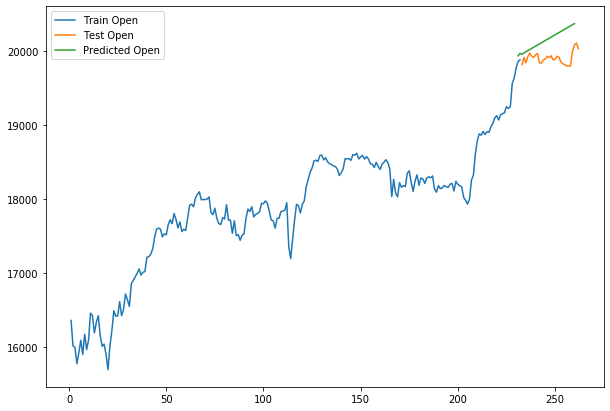

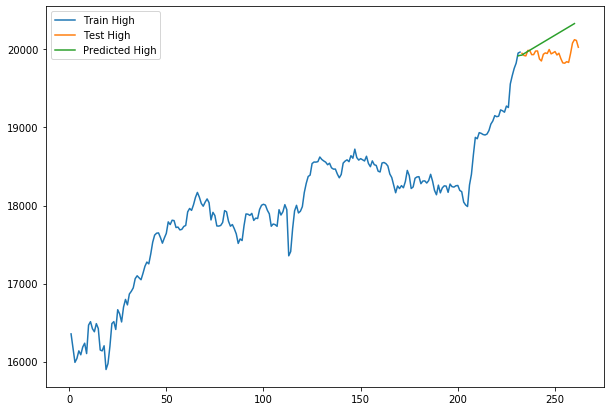

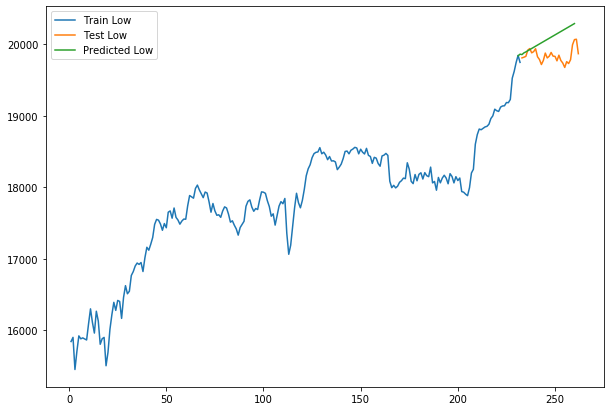

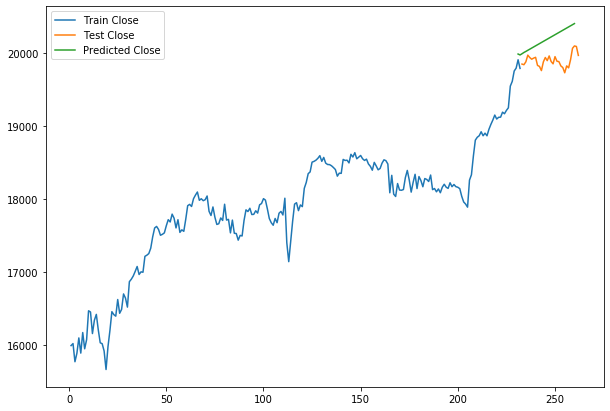

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['Open', 'High', 'Low', 'Close' ]:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot( train[str(i)], label='Train '+str(i))
    plt.plot(test[str(i)], label='Test '+str(i))
    plt.plot(res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()